In [1]:
from itertools import product

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import rotate

from src.models.layers import (conv2d_complex, BCHConv2DComplex, tri,
                               ECHConv2D)


In [2]:
def tri(x):
    return np.where(np.abs(x) <= 1, np.where(x < 0, x + 1, 1 - x), 0)


def get_chs(kernel_size=3, degrees=5):
    radius = (kernel_size - 1) // 2
    x_grid = np.arange(-radius, radius + 1, 1)
    x, y = np.meshgrid(x_grid, x_grid)
    r = np.sqrt(x**2 + y**2)
    theta = np.arctan2(y, x)
    window = np.zeros_like(r)
    # for i in range(kernel_size // 2 + 1):
    #     window[:, :] += tri(r - i)
    window[(r <= radius) & (r >= radius * 0.5)] = 1
    atoms = np.zeros(
        (
            kernel_size,
            kernel_size,
            degrees + 1,
        ),
        dtype=np.csingle,
    )
    window[kernel_size // 2, kernel_size // 2] = 0
    for n in range(degrees + 1):
        atoms[:, :, n] = window * np.exp(theta * n * (1j))
    norm = np.sqrt(np.sum(np.conj(atoms) * atoms, axis=(0, 1)))
    norm[norm == 0] = 1
    return atoms / norm


def get_atoms(kernel_size=3, degrees=5):
    radius = (kernel_size - 1) // 2
    x_grid = np.arange(-radius, radius + 1, 1)
    x, y = np.meshgrid(x_grid, x_grid)
    r = np.sqrt(x**2 + y**2)
    theta = np.arctan2(y, x)
    atoms = np.zeros(
        (
            kernel_size,
            kernel_size,
            degrees + 1,
            kernel_size // 2 + 1,
        ),
        dtype=np.csingle,
    )
    for i, n in product(range(kernel_size // 2 + 1), range(degrees + 1)):
        # atoms[:, :, 0, 0, n, i] = (np.exp(-0.5 * ((r - i) / sigma)**2) *
        #                            np.exp(theta * n * 1j))
        atoms[:, :, n, i] = (tri(r - i) * np.exp(theta * n * (1j)))
    atoms[kernel_size // 2, kernel_size // 2, :, :] = 0
    norm = np.sqrt(np.sum(np.conj(atoms) * atoms, axis=(0, 1)))
    norm[norm == 0] = 1
    # atoms = atoms / norm

    return atoms / norm


In [3]:
max_degree = 5
kernel_size = 9
shs = get_atoms(kernel_size=kernel_size, degrees=max_degree)
shs = np.sum(shs, axis=-1)
# shs = get_chs(kernel_size=kernel_size, degrees=max_degree)

In [4]:
factor = np.zeros((shs.shape[-1]))
factor[1] = 1
# factor[2] = 1
# factor[3] = 1
# factor = np.random.uniform(low=0, high=1.0, size=(shs.shape[-1], ))
f1_proto = factor * shs
# phi = np.random.uniform(low=-np.pi, high=np.pi)
phi = np.pi * 0.25
rotation_factor = np.exp(1j * np.arange(shs.shape[-1]) * phi)
f2_proto = rotation_factor * f1_proto
f1 = np.real(np.sum(f1_proto, axis=-1))
f2 = np.real(np.sum(f2_proto, axis=-1))
f1_rotated = rotate(f1, phi / np.pi * 180, reshape=False)


In [5]:
dot_prod = np.sum((shs[:, :, 1]) * np.conj(shs[:, :,4]))
np.abs(dot_prod)

5.9604645e-08

In [6]:
dot_prod = np.sum((shs[:, :, 5]) * np.conj(f1))
np.abs(dot_prod)

0.19324000516761297

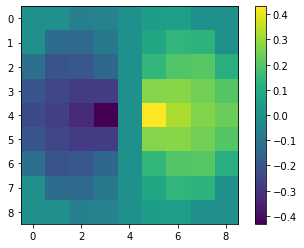

In [7]:
plt.imshow(f1)
plt.colorbar()

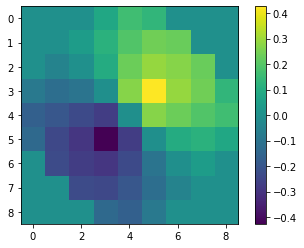

In [8]:
plt.imshow(f1_rotated)
plt.colorbar()

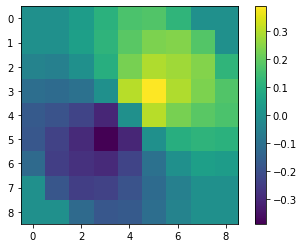

In [9]:
plt.imshow(f2)
plt.colorbar()

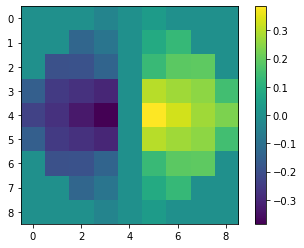

In [10]:
f2_rotated_back = rotate(f2, -phi / np.pi * 180, reshape=False)
plt.imshow(f2_rotated_back)
plt.colorbar()

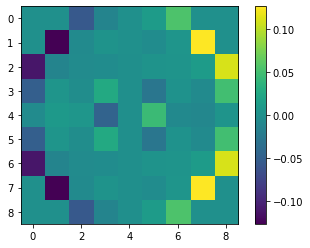

In [11]:
plt.imshow(f1-f2_rotated_back)
plt.colorbar()

In [12]:
layer = ECHConv2D(1,
                  9,
                  max_degree=max_degree,
                  initializer=tf.keras.initializers.Constant(1.0))
# layer = BCHConv2DComplex(1,
#                          9,
#                          max_degree=max_degree,
#                          initializer=tf.keras.initializers.Constant(1.0))


In [13]:
x = np.stack([f1, f2, f1_rotated], axis=0)
x = x[..., np.newaxis]
x = tf.constant(x)

In [14]:
x.shape

TensorShape([3, 9, 9, 1])

In [15]:
y = layer(x).numpy()

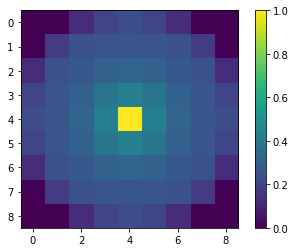

In [16]:
plt.imshow(np.real(np.squeeze(layer.conv_ch.filters.numpy())[...,0]))
plt.colorbar()

In [17]:
central_responses = y[:, 0, 0, :]

In [18]:
np.abs(central_responses[0, ...])


array([7.4345619e-09, 2.4998872e+00, 2.1790830e-08, 1.9324005e-01,
       8.8205878e-09, 1.9323997e-01], dtype=float32)

In [19]:
np.abs(central_responses[1, ...])


array([7.6827993e-09, 2.4998872e+00, 1.9464762e-08, 1.9324005e-01,
       1.1902053e-08, 1.9324005e-01], dtype=float32)

In [34]:
np.abs(central_responses[2, ...])

array([9.495572  , 1.9159117 , 4.418268  , 2.5803454 , 6.3148317 ,
       0.41433862], dtype=float32)

In [35]:
def relative_error(x, xp):
    return np.abs(x - xp) / np.abs(x)


In [36]:
relative_error(central_responses[0, ...], central_responses[1, ...])


array([0.146811  , 0.16521563, 0.11162557, 0.07650324, 0.13696136,
       0.29497233], dtype=float32)

In [ ]:
relative_error(central_responses[0, ...], central_responses[2, ...])